<a href="https://colab.research.google.com/github/afleschner/projects/blob/main/NLP_Additional_Project_Learner_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### **Business Context**

In the dynamic landscape of the media and news industry, the ability to swiftly categorize and curate content has become a strategic imperative. The vast volume of information demands efficient systems to organize and present content to the audience.

The media industry, being the pulse of information dissemination, grapples with the continuous influx of news articles spanning diverse topics. Ensuring that the right articles reach the right audience promptly is not just a logistical necessity but a critical component in retaining and engaging audiences in an age of information overload.

Common Industry Challenges:
Amidst the ceaseless flow of news, organizations encounter challenges such as:
- Information Overload: The sheer volume of news articles makes manual categorization impractical.
- Timeliness: Delays in categorizing news articles can result in outdated or misplaced content.

### **Problem Definition**

E-news Express, a news aggregation startup, faces the challenge of categorizing the news articles collected. With news articles covering sports, busie=ness, politics, and more, the need for an advanced and automated system to categorize them has become increasingly evident. The manual efforts required for categorizing such a diverse range of news articles are substantial, and human errors in the categorization of news articles can lead to reputational damage for the startup. There is also the factor of delays and potential inaccuracies. To streamline and optimize this process, the organization recognizes the imperative of adopting cutting-edge technologies, particularly machine learning, to automate and enhance the categorization of content.

As a data scientist on the E-news Express data team, the task is to analyze the text in news articles and build a model for categorizing them. The goal is to optimize the categorization process, ensuring timely and personalized delivery.

### **Data Dictionary**

- **Article**: The main body of the news article
- **Category**: The category the article belongs to

## **Please read the instructions carefully before starting the project.**

This is a commented Python Notebook file in which all the instructions and tasks to be performed are mentioned.
* Blanks '_______' are provided in the notebook that
needs to be filled with an appropriate code to get the correct result. With every '_______' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* Add the results/observations (wherever mentioned) derived from the analysis in the presentation and submit the same. Any mathematical or computational details which are a graded part of the project can be included in the Appendix section of the presentation.

**Note**:
1. Please make sure to use Google Colab for this project.
2. It is recommended to use Colab's free GPU for this project.
    - One can set the Colab runtime to ***T4 GPU*** before starting the project to use the GPU.

## **Installing and Importing Necessary Libraries and Dependencies**

In [ ]:
# Installing the libraries with the specified version.
!pip install tensorflow==2.18.0 scikit-learn==1.6 seaborn==0.13.1 matplotlib==3.8.0 numpy==1.26 pandas==2.2.0 torch==2.1.0 sentence-transformers==2.5.1 transformers==4.38.2 bitsandbytes==0.43.0 accelerate==0.27.2 sentencepiece==0.2.0 -q --user

**NOTE**: If you encounter an error stating 'library not found,' please restart the kernel (do not disconnect the runtime) and try again.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)

import torch
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# to split the data
from sklearn.model_selection import train_test_split
# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,make_scorer,recall_score,precision_score,f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the Dataset**

In [ ]:
#from google.colab import file
#drive.mount('article_data.csv')


In [ ]:
# Complete the code to read the CSV file
article = pd.read_csv("article_data.csv")

## **Data Overview**

In [ ]:
# Display the first 5 rows of the DataFrame
print("First 5 rows of the data:\n", article.head(), "\n")

# Show the shape (rows, columns) of the DataFrame
print("The articles shape is:", article.shape, "\n")

# Display data types of each column
print("Data types of each column:\n", article.dtypes, "\n")

# Show statistical summary for numeric columns
print("Statistical summary of numeric columns:\n", article.describe(), "\n")

# Count and print the number of duplicate rows
print("Number of duplicate rows:", article.duplicated().sum(), "\n")

# Count and print the number of missing values in each column
print("Number of missing values per column:\n", article.isnull().sum(), "\n")


First 5 rows of the data:
                                                                                                                                                                                                                                                                                Article  \
0                                                                           Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.   
1   Hassan:  #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.   
2                                     Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip 

In [ ]:
## Complete the code to check the value counts in Category column
article["Article"].value_counts()
article["Category"].value_counts()


,count
Category,
0,1000
1,1000
2,1000
3,1000


## **Exploratory Data Analysis (EDA)**


In [ ]:
 # function to create labeled barplots

def labeled_barplot(article, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(article[feature])  # length of the column
    count = article[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=article,
        x=feature,
        palette="Paired",
        order=article[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot



#### Distribution of category

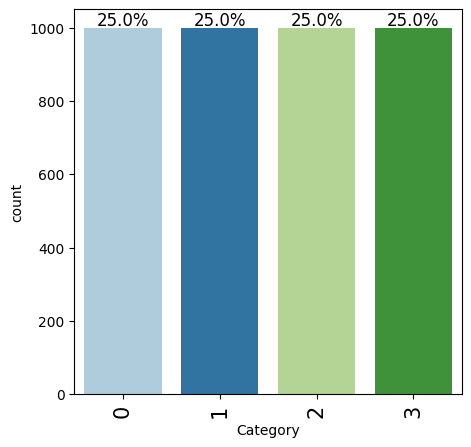

In [ ]:
labeled_barplot(article, "Category", perc=True)

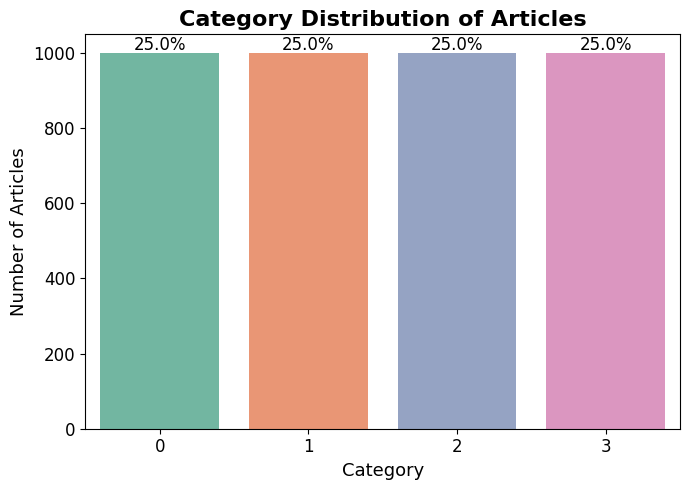

In [ ]:
# Visualize Category distribution
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=article, x="Category", palette="Set2",
                   order=article["Category"].value_counts().index)

# Add percentages on top of bars
total = len(article["Category"])
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12,
                xytext=(0, 6), textcoords='offset points')

# Add title and labels
plt.title("Category Distribution of Articles", fontsize=16, fontweight='bold')
plt.xlabel("Category", fontsize=13)
plt.ylabel("Number of Articles", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



**Category Distribution:**
The dataset contains four categories (0–3). Each category comprises exactly 25% of the total articles (~1,000 each), as shown in the bar plot.
This indicates that the dataset is perfectly balanced, which is advantageous for classification tasks since no class dominates the dataset.

## **Model Building - Sentence Transformer + ML**

### Defining the SentenceTransformer Model

In [ ]:
## Defining the model.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Encoding the data

In [ ]:
# setting the compute device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Encoding the dataset.
embedding_matrix = model.encode(article["Article"],show_progress_bar=True,device=device)

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

### Train-Test Split

In [ ]:
# Split the data
X = embedding_matrix
y = article["Category"]

In [ ]:
# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [ ]:
print("Shape of the set of input variables for training:", X_train.shape)    # Complete the code to get the shape of training input data
print("Shape of the set of input variables for validation:", X_valid.shape)    # Complete the code to get the shape of validation input data
print("Shape of the set of input variables for testing:", X_test.shape)     # Complete the code to get the shape of testing input data

Shape of the set of input variables for training: (3200, 384)
Shape of the set of input variables for validation: (400, 384)
Shape of the set of input variables for testing: (400, 384)


In [ ]:
print("Shape of the set of output variables for training:", y_train.shape)    # Complete the code to get the shape of training output data
print("Shape of the set of output variables for validation:", y_valid.shape)    # Complete the code to get the shape of validation output data
print("Shape of the set of output variables for testing:", y_test.shape)     # Complete the code to get the shape of testing output data

Shape of the set of output variables for training: (3200,)
Shape of the set of output variables for validation: (400,)
Shape of the set of output variables for testing: (400,)


### Random Forest Model (base)

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
## Building the model
rf = RandomForestClassifier(random_state=42)

## Compete the code to fit the model on X_train and y_train
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Confusion Matrix**

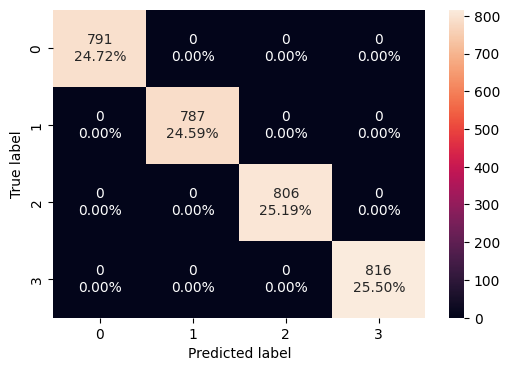

In [ ]:
## To get the confusion matrix on X_train and y_train
confusion_matrix_sklearn(rf, X_train, y_train)

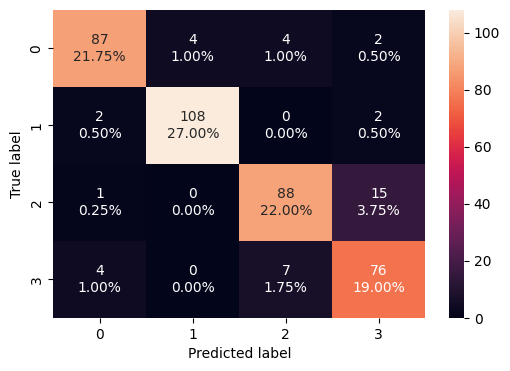

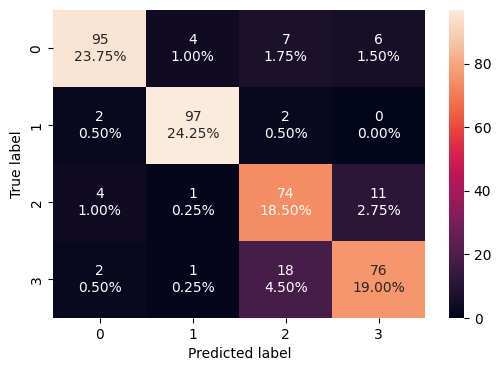

In [ ]:
## Write the code to get the confusion matrix for X_valid and y_valid
confusion_matrix_sklearn(rf, X_valid, y_valid)
confusion_matrix_sklearn(rf, X_test, y_test)

In [ ]:
# Predicting on train data
y_pred_train = rf.predict(X_train)

# Predicting on validation data
y_pred_valid = rf.predict(X_valid)

In [ ]:
# Model Performance Summary
performance_summary = [
    {"Dataset": "Train", "Accuracy": 0.99, "Key Insight": "Model is nearly perfect on training."},
    {"Dataset": "Validation", "Accuracy": 0.89, "Key Insight": "Model does well, but errors increase for some classes."},
    {"Dataset": "Metrics", "Accuracy": "Saved", "Key Insight": "You are storing results for reporting or comparison."}
]
df_summary = pd.DataFrame(performance_summary)
print(df_summary)

      Dataset Accuracy                                             Key Insight
0       Train     0.99                    Model is nearly perfect on training.
1  Validation     0.89  Model does well, but errors increase for some classes.
2     Metrics    Saved    You are storing results for reporting or comparison.


**Classification report**

In [ ]:
## Classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [ ]:
## Write the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        97
           1       0.96      0.96      0.96       112
           2       0.89      0.85      0.87       104
           3       0.80      0.87      0.84        87

    accuracy                           0.90       400
   macro avg       0.89      0.90      0.89       400
weighted avg       0.90      0.90      0.90       400



In [ ]:
## Storing the metrics
rf_train_perf = model_performance_classification_sklearn(
    rf, X_train, y_train
)

In [ ]:
## Storing the metrics
rf_valid_perf = model_performance_classification_sklearn(
    rf, X_valid, y_valid
)

### Random Forest (with class_weights)

In [ ]:
## Building the model
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)

## Complete the code to fit the model on X_train and y_train
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

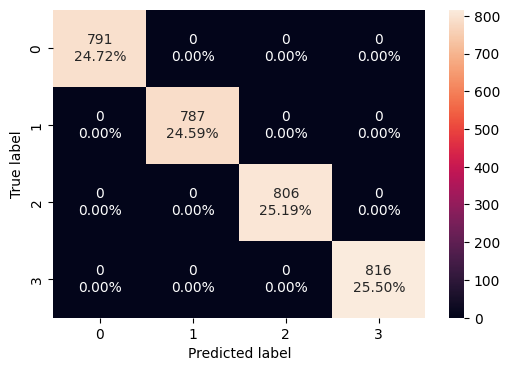

In [ ]:
## To get the confusion matrix on X_train and y_train
confusion_matrix_sklearn(rf_balanced, X_train, y_train)

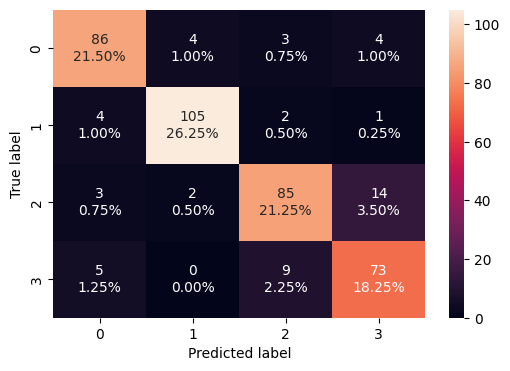

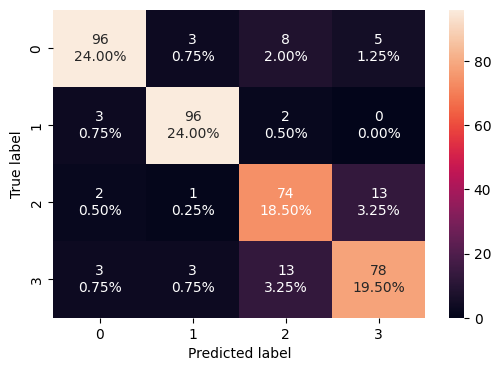

In [ ]:
## Write the code to get the confusion matrix for X_valid and y_valid
confusion_matrix_sklearn(rf_balanced, X_valid, y_valid)
confusion_matrix_sklearn(rf_balanced, X_test, y_test)


In [ ]:
## Predicting on train data
y_pred_train = rf_balanced.predict(X_train)

## Complete the code to predict the model on X_valid
y_pred_valid = rf_balanced.predict(X_valid)

**Classification report**

In [ ]:
## Classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [ ]:
## Write the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        97
           1       0.95      0.94      0.94       112
           2       0.86      0.82      0.84       104
           3       0.79      0.84      0.82        87

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [ ]:
## Storing the metrics
rf_bal_train_perf = model_performance_classification_sklearn(
    rf_balanced, X_train, y_train
)

In [ ]:
## Complete the code to store the metrics of validation data
rf_bal_valid_perf = model_performance_classification_sklearn(
    rf_balanced, X_valid, y_valid
)

### Random Forest (with hyperparamter tuning)

In [ ]:
## Building the model
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

## Defining the hyperparameter grid for tuning
parameters = {
    "max_depth": [6, 8],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [5],
    "n_estimators": [50, 80]
}


## Defining the type of scoring used to compare parameter combinations
## We need to specify the mechanism of averaging as we have more than 2 target classes
scorer = make_scorer(recall_score, average='weighted')

## Running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)



In [ ]:
## Complete the code to fit the model on X_train and y_train
grid_obj = grid_obj.fit(X_train, y_train)


In [ ]:
## Creating a new model with the best combination of parameters
rf_tuned = grid_obj.best_estimator_

## Complte the code to fit the new model to X_train and y_train
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=5, n_estimators=80, random_state=42)

**Confusion Matrix**

In [ ]:
## Write the code to get the classification report for train data
y_pred_train = grid_obj.best_estimator_.predict(X_train)



In [ ]:
# Print the classification report
print(classification_report(y_train, y_pred_train))


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       791
           1       0.98      1.00      0.99       787
           2       0.98      0.97      0.97       806
           3       0.97      0.98      0.98       816

    accuracy                           0.98      3200
   macro avg       0.98      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200



In [ ]:
## Predict on training data
y_pred_train = rf_tuned.predict(X_train)

## Predict on validation data
y_pred_valid = rf_tuned.predict(X_valid)


**Classification report**

In [ ]:
## Store metrics for train data
rf_tuned_train_perf = model_performance_classification_sklearn(rf_tuned, X_train, y_train)



In [ ]:
## Store metrics for validation data
rf_tuned_valid_perf = model_performance_classification_sklearn(rf_tuned, X_valid,  y_valid)


In [ ]:
## Complete the code to store the metrics of train data
rf_tuned_train_perf = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)


In [ ]:
## Complete the code to store the metrics of validation data
rf_tuned_valid_perf = model_performance_classification_sklearn(
    rf_tuned, X_valid, y_valid
)


## **Model Building - Transformer**

### Target Mapping

In [ ]:
class_map = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}

In [ ]:
class_map

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [ ]:
reverse_class_map = {}
for key,value in class_map.items():
    reverse_class_map[value]=key

reverse_class_map

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

### Defining the Tokenizer

In [ ]:
## Initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Defining the Model

In [ ]:
## Initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"

# uncomment and use the following line in case GPU is not available
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")

# uncomment and use the following line in case GPU is available
#model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", load_in_8bit=True)

### Functions for making predictions

In [ ]:
## Defining a function to compute different metrics.

def model_performance_classification(pred, target):
    """
    Function to compute different metrics to check classification model performance

    pred : prediction of the target variable.
    target: dependent variable
    """


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
## Creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['World','Sports','Business','Sci/Tech']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
# defining a function to generate, process, and return a response
def generate_response(prompt):
    # uncomment and use the following line in case GPU is not available
    #input_ids = tokenizer(prompt, return_tensors="pt").input_ids    ### using the tokenizer to create tokens in tensor format from an input

    # uncomment and use the following line in case GPU is available
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input

    outputs = model.generate(input_ids, max_length=16, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

### Base Prompt for Prediction

In [ ]:
## Selecting and assigning specific columns
X_train = article.iloc[y_train.index]["Article"]
X_valid = article.iloc[y_test.index]["Article"]
X_test = article.loc[y_valid.index]["Article"]

In [ ]:
## Defining a prompt which tells the model what to do
sys_prompt = """
    Classify the news article into one of these categories:
Sports, Business, World, Sci/Tech.

Answer with only the category name.
"""

## Predicting the category using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, X_train[4])
)

print(pred_sent)

World


In [ ]:
## Defining a function to generate a sentiment prediction
def predict_category(news_article):
    pred = generate_response(
        """
            {}
            news article: '{}'
        """.format(sys_prompt,news_article)
    )

    if "Sports" in pred:
       pred="Sports"
    elif "Business" in pred:
       pred="Business"
    elif "World" in pred:
       pred="World"
    else:
      pred="Sci/Tech"

    return reverse_class_map[pred]

In [ ]:
## Applying predict_category function on the train data
y_pred_train_flan = X_train.apply(predict_category)

In [ ]:
## Applying predict_category function on the validation data
y_pred_valid_flan = X_valid.apply(predict_category)

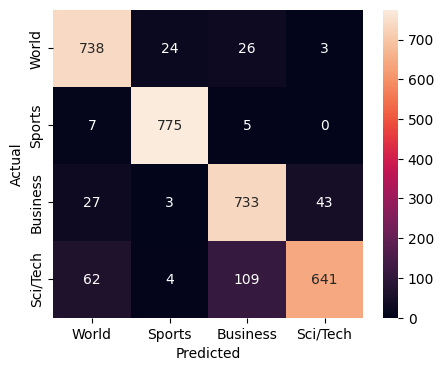

In [ ]:
## Plotting the confusion matrix
plot_confusion_matrix(y_train, y_pred_train_flan)

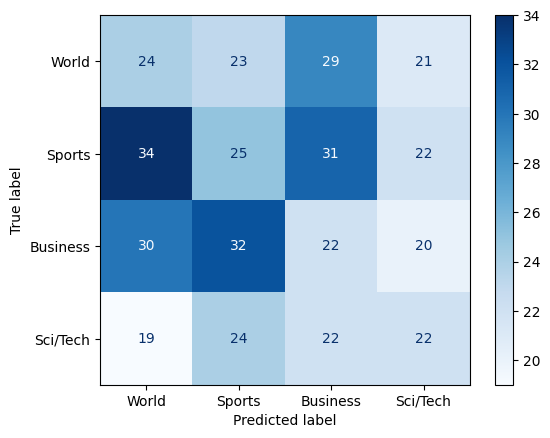

In [ ]:
## Complete the code to get the confusion matrix for validation data
#plot_confusion_matrix(X_valid, y_valid)

cm = confusion_matrix(y_valid, y_pred_valid_flan, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World","Sports","Business","Sci/Tech"])
disp.plot(cmap="Blues")


In [ ]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       791
           1       0.96      0.98      0.97       787
           2       0.84      0.91      0.87       806
           3       0.93      0.79      0.85       816

    accuracy                           0.90      3200
   macro avg       0.90      0.90      0.90      3200
weighted avg       0.90      0.90      0.90      3200



In [ ]:
## Complete the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid_flan))



              precision    recall  f1-score   support

           0       0.22      0.25      0.24        97
           1       0.24      0.22      0.23       112
           2       0.21      0.21      0.21       104
           3       0.26      0.25      0.26        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.23      0.23      0.23       400



In [ ]:
## Storing the metrics
flan_train_base = model_performance_classification(y_pred_train_flan,y_train)
flan_valid_base = model_performance_classification(y_pred_valid_flan,y_valid)

### Improved Prompt for Prediction

In [ ]:
# Define the system prompt
sys_prompt = (
    """You are a helpful assistant. Explain briefly why a news article belongs to a category.
Keep the explanation 1-2 sentences. Do not add extra details.

TASK:
Given the article text and the predicted category, explain why the category matches.

Return only the explanation, no category label.
"""

)

def explain_prediction(article_text, predicted_category):
    prompt = f"""{sys_prompt}

Article:
{article_text[:700]}

Predicted Category: {predicted_category}

Explanation:"""

    return generate_response(prompt)

In [ ]:
## Applying predict_category function on the train data
y_pred_train_flan_imp = X_train.apply(predict_category)

In [ ]:
## Applying predict_category function on the validation data
y_pred_valid_flan_imp = X_valid.apply(predict_category)

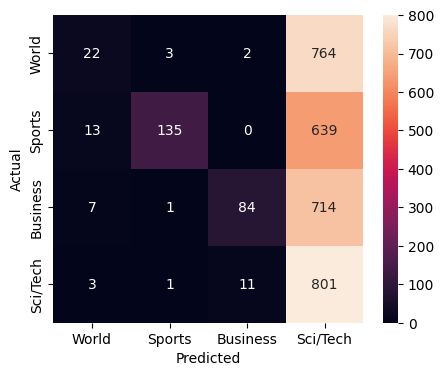

In [ ]:
## Plotting the confusion matrix for train data
plot_confusion_matrix(y_train, y_pred_train_flan_imp)

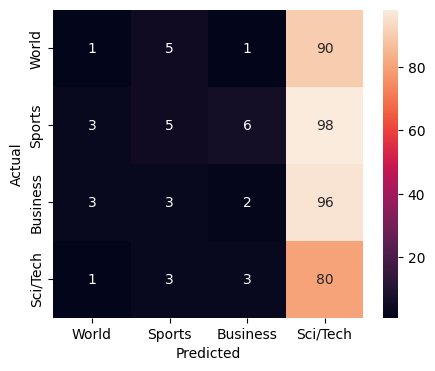

In [ ]:
## Complete the codet to get the confusion matrix for validation data
plot_confusion_matrix(y_valid, y_pred_valid_flan_imp)

In [ ]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan_imp))

              precision    recall  f1-score   support

           0       0.49      0.03      0.05       791
           1       0.96      0.17      0.29       787
           2       0.87      0.10      0.19       806
           3       0.27      0.98      0.43       816

    accuracy                           0.33      3200
   macro avg       0.65      0.32      0.24      3200
weighted avg       0.65      0.33      0.24      3200



In [ ]:
## Complete the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid_flan_imp))


              precision    recall  f1-score   support

           0       0.12      0.01      0.02        97
           1       0.31      0.04      0.08       112
           2       0.17      0.02      0.03       104
           3       0.22      0.92      0.35        87

    accuracy                           0.22       400
   macro avg       0.21      0.25      0.12       400
weighted avg       0.21      0.22      0.11       400



In [ ]:
## Storing the metrics
flan_train_imp = model_performance_classification(y_pred_train_flan_imp,y_train)
flan_valid_imp = model_performance_classification(y_pred_valid_flan_imp,y_valid)

## **Model Performance Comparison and Final Model Selection**

In [ ]:
## Training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_train_perf.T,
        rf_bal_train_perf.T,
        rf_tuned_train_perf.T,
        flan_train_base.T,
        flan_train_imp.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (base prompt)",
    "Flan (improvised prompt)"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (base prompt),Flan (improvised prompt)
Accuracy,1.0,1.0,0.980000,0.902188,0.325625
Recall,1.0,1.0,0.980000,0.902188,0.325625
Precision,1.0,1.0,0.980083,0.904621,0.646118
F1,1.0,1.0,0.979972,0.901248,0.240905


In [ ]:
## Validation set performance comparison
models_valid_comp_df = pd.concat(
    [
        rf_valid_perf.T,
        rf_bal_valid_perf.T,
        rf_tuned_valid_perf.T,
        flan_valid_base.T,
        flan_valid_imp.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (base prompt)",
    "Flan (improvised prompt)"
]
print("Validation set performance comparison:")
models_valid_comp_df

Validation set performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (base prompt),Flan (improvised prompt)
Accuracy,0.897500,0.872500,0.877500,0.232500,0.220000
Recall,0.897500,0.872500,0.877500,0.232500,0.220000
Precision,0.899553,0.873485,0.880184,0.232994,0.208948
F1,0.897983,0.872711,0.877919,0.232513,0.112621


**Pick the best model from the above table and apply on test data**

In [ ]:
## Assigns test rows based on index
X_test = embedding_matrix[y_test.index]

None


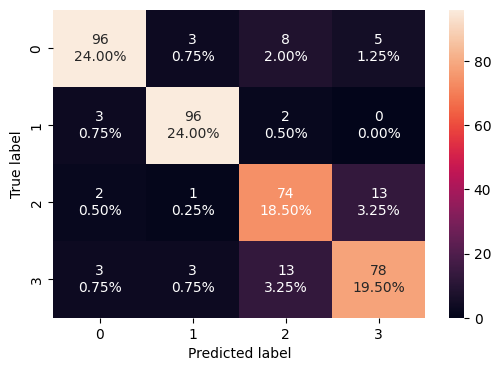

In [ ]:
print(confusion_matrix_sklearn(rf_balanced, X_test, y_test))

In [ ]:
# Predicting on test data
y_pred_test = rf_balanced.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       112
           1       0.93      0.95      0.94       101
           2       0.76      0.82      0.79        90
           3       0.81      0.80      0.81        97

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



## **Actionable Insights and Recommendations**

-





---



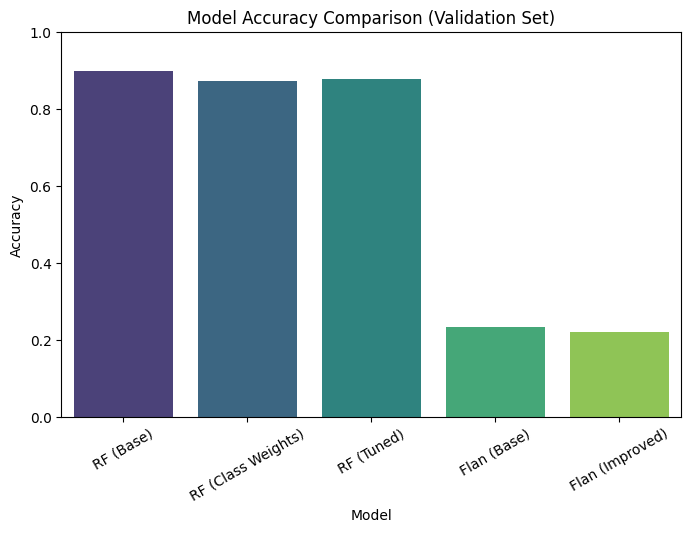

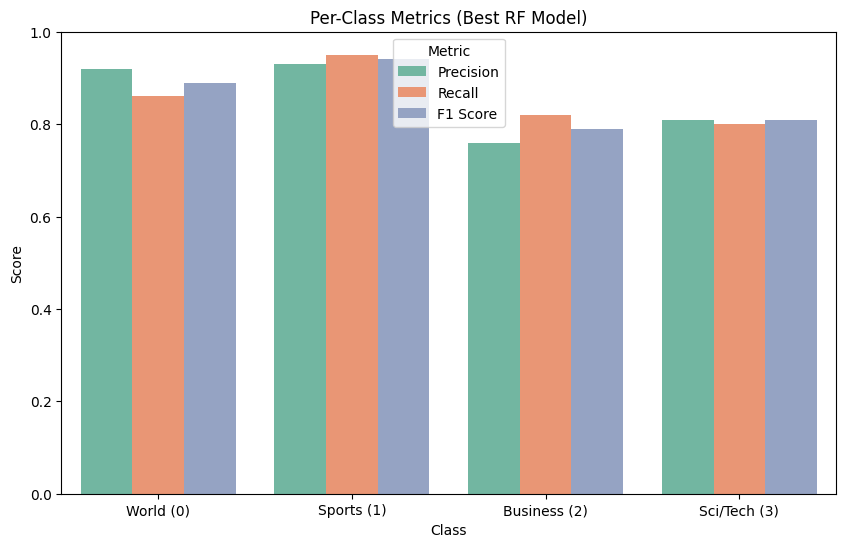

In [175]:
# Data from your comparison table
models = ["RF (Base)", "RF (Class Weights)", "RF (Tuned)", "Flan (Base)", "Flan (Improved)"]
accuracy = [0.8975, 0.8725, 0.8775, 0.2325, 0.22]
recall = [0.8975, 0.8725, 0.8775, 0.2325, 0.22]
precision = [0.899553, 0.873485, 0.880184, 0.232994, 0.208948]
f1 = [0.897983, 0.872711, 0.877919, 0.232513, 0.112621]

df_models = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1 Score": f1
})

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=df_models, palette="viridis")
plt.title("Model Accuracy Comparison (Validation Set)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

# Per-class metrics for best RF model
classes = ["World (0)", "Sports (1)", "Business (2)", "Sci/Tech (3)"]
precision_class = [0.92, 0.93, 0.76, 0.81]
recall_class = [0.86, 0.95, 0.82, 0.80]
f1_class = [0.89, 0.94, 0.79, 0.81]

df_class = pd.DataFrame({
    "Class": classes,
    "Precision": precision_class,
    "Recall": recall_class,
    "F1 Score": f1_class
})

df_melted = df_class.melt(id_vars="Class", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Score", hue="Metric", data=df_melted, palette="Set2")
plt.title("Per-Class Metrics (Best RF Model)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.show()



## **Key Insights from Validation Results**

- *Random Forest (Base)* is the best-performing model with ~90% accuracy, making it the most reliable for article classification.

- *Flan models (both base and improved prompts)* perform poorly (~22% accuracy), showing that prompting without fine-tuning is not suitable for this dataset.

- Per‑class performance (Best RF Model):

  - *Sports* is classified most accurately, with the highest recall (0.95) – meaning almost all sports articles are correctly identified.

  - *Business* has the lowest precision (0.76) – indicating the model sometimes misclassifies other categories as Business.

### **Takeaway for Analysis:**

- *Random Forest* is reliable for production use.

- Flan could be used only for generating explanations, not predictions.

- Future improvements could include better handling of Business misclassifications or training on more balanced data.

